# XANES analysis

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import itertools
import scipy.optimize

from scipy.optimize import curve_fit
from scipy.optimize import minimize
from lmfit.models import PseudoVoigtModel


In [ ]:

import seaborn as sns
import matplotlib.ticker
import statistics
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from itertools import combinations
from matplotlib.transforms import Affine2D
from scipy import stats
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman' 
plt.rcParams['mathtext.it'] = 'Times New Roman:italic' 

from scipy.stats import mannwhitneyu

In [ ]:
os.chdir("C:\\Users\\[DATA FILE NAME]")

In [3]:
def Calc(std,x):
    global y
    y=[]
    for i in range(len(std)):
        y.append(std[i]*x[i])
    total = sum(y)
    return(total)

def Rval(x):
        R = sum((Calc(std_group,x) -  target)**2)/sum(target**2)#この計算式２条がsumのカッコ内に入る
        return(R)

def Rval2 (x):
    R = sum((Calc(logstd,x) -  target)**2) / sum(target**2)#この計算式２条がsumのカッコ内に入る
    return(R)

In [6]:
"""Import files"""
spectrum=[[],[],[],[]]
n,m = 1, 1

for filename in glob.glob("*.xan*"):
    p = pd.read_csv(filename, encoding = "CP932")
    
    for i in range(len(p)):
        if p["[XAN_DATA]"][i]=="[BG_BEGIN]":
            n = i
        elif p["[XAN_DATA]"][i]=="[BG_END]":
            m = i
        else: continue
    
    data = pd.read_csv(filename,encoding="SHIFT_JIS",sep=('\t'),usecols=[1,2,3],names=[1,2,3],
                       skiprows=n+3)[1:m-n]
    spectrum[0].append(data[1])
    spectrum[1].append(data[2])
    spectrum[2].append(filename)
    spectrum[3].append(data[3])


In [7]:
print("sample list")
for i in range(len(spectrum[2])):
    print(str(i)+"  "+spectrum[2][i])

sample list
0  03-RM-frozen.xan
1  210515hematite.xan
2  220205hematite_dat.xan
3  220702hematite.xan
4  230508_MKR_02-Blood-dry.xan
5  230508_MKR_02-RM-dry.xan
6  230508_MKR_03-Blood-dry.xan
7  230508_MKR_03-Liv-dry.xan
8  230508_MKR_03-Ova-dry.xan
9  230508_MKR_03-RM-dry.xan
10  230508_MKR_03-RM-frozen.xan
11  230508_MKR_03-spl-dry.xan
12  230508_MKR_04-RM-frozen-Re.xan
13  230508_MKR_05-Blood-dry.xan
14  230508_MKR_05-RM-dry.xan
15  230508_MKR_05-RM-Frozen.xan
16  230508_MKR_08-RM-frozen-Re.xan
17  ammonium_oxalate_Fe_dat.xan
18  biotite_dat.xan
19  copepoda_Oarai_frozen.xan
20  copepod_Manazuru.xan
21  Deoxyhemoglobin-10-SDD-2.xan
22  Deoxyhemoglobin-10-SDD.xan
23  Deoxyhemoglobin-10sol-sdd-re.xan
24  Deoxyhemoglobin-10sol-sdd.xan
25  Deoxyhemoglobin-20sol-sdd.xan
26  Deoxyhemoglobin-50sol-sdd.xan
27  Fe3O4_dat.xan
28  FeC2O4_2H2O_dat.xan
29  ferrihydrite-2.xan
30  ferrihydrite_dat.xan
31  ferritin_EX_long_dat.xan
32  FeS_dat.xan
33  goethite_dat.xan
34  hematite_2nd_0_s_intp.xan
3

## Spectrum fitete by standard materials

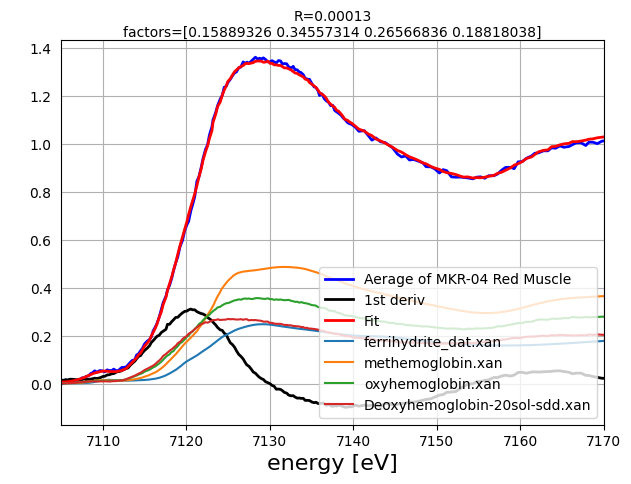

target: MKR_04_red_muscle_sdd.xan
standards: ['ferrihydrite_dat.xan', 'methemoglobin.xan', 'oxyhemoglobin.xan', 'Deoxyhemoglobin-20sol-sdd.xan']
factors: [0.15889326 0.34557314 0.26566836 0.18818038]
R =  0.00013


In [12]:
Muscle_Results, Rvals, FitResult, FitEnergy =[],[],[],[]

M1,M2=57,58 # File numbers of sample spectra with multiple times of measurement 
standards = [30,47,78,25] # File numbers of standard spectra

%matplotlib inline
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot()
ax.set_xlabel("energy [eV]",fontsize=16)
ax.set_ylabel(" ")
ax.set_xlim(7105, 7170)
ax.grid()
ax.tick_params(left=False)

n=300 #Fitting data range
Muscle = (spectrum[1][M1][0:n] + spectrum[1][M2][0:n])/2
target = Muscle

result = []
Rval_before = 1

t = len(standards)
for v in itertools.combinations(standards, t):
    std_group = [[1]]*t
    for i in range(t):
        std_group[i] = spectrum[1][v[i]][0:n]

    #Initial value
    x0=[(1/t)]*t
    bounds=[(0,1)]*t # 0 < factor < 1

Fit = scipy.optimize.minimize(Rval,x0=x0,bounds=bounds)
if (Rval(Fit.x) <= Rval_before):
    result=Fit.x
    Rval_before = Rval(Fit.x)
    log=(v)
    logstd=std_group

energy =  [float(i) for i in spectrum[0][M1]]
energy_n =  [float(i) for i in spectrum[0][M1][0:n]]

ax.plot(energy_n,Muscle,color="blue",linewidth = 2, label="Aerage of MKR-04 Red Muscle")

# Calculation of 1st derivative
test_y=np.ediff1d(Muscle)
n_conv = 30
b = np.ones(n_conv)/n_conv 
test_y=np.convolve(test_y, b, mode="same")
ax.plot(energy_n[1:],test_y*10,color="black",linewidth = 2, label="1st deriv")

ax.plot(energy_n,Calc(logstd, result),color="red",linewidth = 2, label="Fit")

FitResult.append(Calc(logstd, result))
FitEnergy.append(energy_n)
stdname, value2=[],[]

for m in range(len(log)):
    stdname.append(spectrum[2][log[m]])
    energy =  [float(i) for i in spectrum[0][log[m]]]
    value = spectrum[1][log[m]]*result[m]
    value2.append(value[0:341])
    ax.plot(energy,value, label=spectrum[2][log[m]])

ax.legend(loc="lower right", fontsize=10)
plt.title("R="+str(round(Rval2(result),5))+"\n"+"factors="+str(result) ,size=10,transform=ax.transAxes)
plt.show()
print("target:", spectrum[2][M2])
print("standards:",stdname)
print("factors:",result)
print("R = ", str(round(Rval2(result),5)))
Muscle_Results.append(result)
Rvals.append(Rval2(result))
   

## Pre-edge analysis

In [13]:
Params=[]
print("sample list")
for i in range(len(spectrum[2])):
    print(str(i)+"  "+spectrum[2][i])

sample list
0  03-RM-frozen.xan
1  210515hematite.xan
2  220205hematite_dat.xan
3  220702hematite.xan
4  230508_MKR_02-Blood-dry.xan
5  230508_MKR_02-RM-dry.xan
6  230508_MKR_03-Blood-dry.xan
7  230508_MKR_03-Liv-dry.xan
8  230508_MKR_03-Ova-dry.xan
9  230508_MKR_03-RM-dry.xan
10  230508_MKR_03-RM-frozen.xan
11  230508_MKR_03-spl-dry.xan
12  230508_MKR_04-RM-frozen-Re.xan
13  230508_MKR_05-Blood-dry.xan
14  230508_MKR_05-RM-dry.xan
15  230508_MKR_05-RM-Frozen.xan
16  230508_MKR_08-RM-frozen-Re.xan
17  ammonium_oxalate_Fe_dat.xan
18  biotite_dat.xan
19  copepoda_Oarai_frozen.xan
20  copepod_Manazuru.xan
21  Deoxyhemoglobin-10-SDD-2.xan
22  Deoxyhemoglobin-10-SDD.xan
23  Deoxyhemoglobin-10sol-sdd-re.xan
24  Deoxyhemoglobin-10sol-sdd.xan
25  Deoxyhemoglobin-20sol-sdd.xan
26  Deoxyhemoglobin-50sol-sdd.xan
27  Fe3O4_dat.xan
28  FeC2O4_2H2O_dat.xan
29  ferrihydrite-2.xan
30  ferrihydrite_dat.xan
31  ferritin_EX_long_dat.xan
32  FeS_dat.xan
33  goethite_dat.xan
34  hematite_2nd_0_s_intp.xan
3

In [17]:
data_num, data_num_2 = 22, 23 #averaging 2 times of measurements

%matplotlib qt
print("Select start and end points of XANES area")
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.set_xlabel("energy [eV]",fontsize=16)
ax.set_ylabel(" ")
ax.set_xlim(7090, 7200)
ax.grid()
ax.tick_params(left=False)
data_range = []

def onclick(event):
    if event.xdata == None or event.ydata == None:
        return
    else:
        print( 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %(
            event.button, event.x, event.y, event.xdata, event.ydata))
        data_range.append(event.xdata)
    

fig.canvas.mpl_connect('button_press_event', onclick)
energy = [float(i) for i in spectrum[0][data_num]]
line = (spectrum[1][data_num]+ spectrum[1][data_num_2])/2
ax.scatter(energy,line,linewidth = 3,label=spectrum[2][data_num])
plt.title(spectrum[2][data_num])

Select start and end points of XANES area


Text(0.5, 1.0, 'Deoxyhemoglobin-10-SDD.xan')

button=1, x=332, y=150, xdata=7103.673118, ydata=0.008842
button=1, x=424, y=195, xdata=7112.473118, ydata=0.092625


In [ ]:
data_num = 25

%matplotlib qt
print("Select stat and end points of pre-edge area")
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.set_xlabel("energy [eV]",fontsize=16)
ax.set_ylabel(" ")
ax.set_xlim(7090, 7200)
ax.grid()
ax.tick_params(left=False)
data_range = []

def onclick(event):
    if event.xdata == None or event.ydata == None:
        return
    else:
        print( 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %(
            event.button, event.x, event.y, event.xdata, event.ydata))
        data_range.append(event.xdata)
    

fig.canvas.mpl_connect('button_press_event', onclick)
energy = [float(i) for i in spectrum[0][data_num]]
line = spectrum[1][data_num] 
ax.scatter(energy,line,linewidth = 3,label=spectrum[2][data_num])
plt.title(spectrum[2][data_num])


Select stat and end points of pre-edge area


Text(0.5, 1.0, 'Deoxyhemoglobin-20sol-sdd.xan')

button=1, x=345, y=144, xdata=7104.903226, ydata=-0.003706
button=1, x=423, y=194, xdata=7112.283871, ydata=0.099130


In [ ]:
select_0 = np.ones(len(spectrum[0][data_num]))* data_range[0]
select_1 = np.ones(len(spectrum[0][data_num]))* data_range[1]

x = [float(s) for s in spectrum[0][data_num]]

select_x_0 = abs(x-select_0)
select_x_0=select_x_0.tolist()
select_x_00=select_x_0.index(min(select_x_0))

select_x_1 = abs(x-select_1)
select_x_1=select_x_1.tolist()
select_x_11 = select_x_1.index(min(select_x_1))


select_range = [spectrum[0][data_num][select_x_00:select_x_11], spectrum[1][data_num][select_x_00:select_x_11]]
%matplotlib qt
print("Select stat and end points of XANES area")
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.set_xlabel("energy [eV]",fontsize=16)
ax.set_ylabel(" ")
ax.grid()
ax.tick_params(left=False)
data_range = []

fig.canvas.mpl_connect('button_press_event', onclick)

energy = [float(s) for s in select_range[0]] 
line = [float(s) for s in select_range[1]] 

ax.scatter(energy,line,linewidth = 3,label=spectrum[2][data_num])
plt.title(spectrum[2][data_num])

Select stat and end points of XANES area


Text(0.5, 1.0, 'Deoxyhemoglobin-20sol-sdd.xan')

button=1, x=459, y=202, xdata=7106.275306, ydata=0.015306
button=1, x=1117, y=575, xdata=7110.776958, ydata=0.048910


Text(0.5, 1.0, 'Deoxyhemoglobin-20sol-sdd.xan')

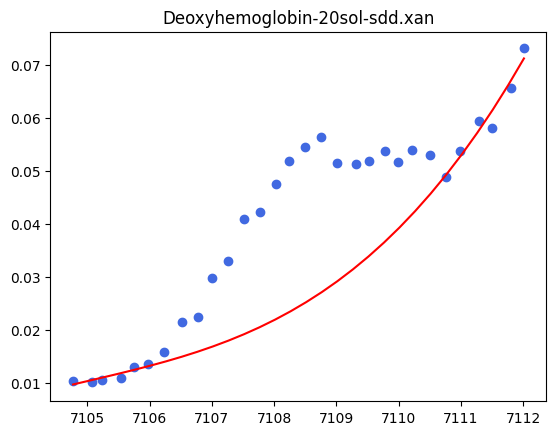

In [34]:
select_0 = np.ones(len(select_range[0]))* data_range[0]
select_1 = np.ones(len(select_range[1]))* data_range[1]

x = [float(s) for s in select_range[0]]

select_x_0 = abs(x-select_0)
select_x_0=select_x_0.tolist()
select_x_00=select_x_0.index(min(select_x_0))

select_x_1 = abs(x-select_1)
select_x_1=select_x_1.tolist()
select_x_11 = select_x_1.index(min(select_x_1))

'Smoothing spline'
length = len(select_range[0])
background = [pd.concat([select_range[0][0:select_x_00],select_range[0][select_x_11:length]]),
              pd.concat([select_range[1][0:select_x_00],select_range[1][select_x_11:length]])]

from scipy import signal, interpolate

x = [float(s) for s in background[0]]
y = [float(s) for s in background[1]]

reg = interpolate.UnivariateSpline(x,y)
xs = np.linspace(x[0], x[len(x)-1], len(select_range[0]))

regy = reg(xs)
%matplotlib inline
plt.plot(xs,regy, color="red")
plt.scatter(energy, line, color="royalblue")
plt.title(spectrum[2][data_num])

In [ ]:
'Background subtraction'
raw_data = [float(s) for s in select_range[1]]
subtract = raw_data - regy
energy = [float(s) for s in select_range[0]]
"Fitted by Pseudo-Voigt function"
model=PseudoVoigtModel()
data_y = np.array(subtract)
data_x = np.array(energy)
params = model.guess(data_y, x=data_x)
result = model.fit(data_y, params, x=data_x)
result.fit_report.__self__

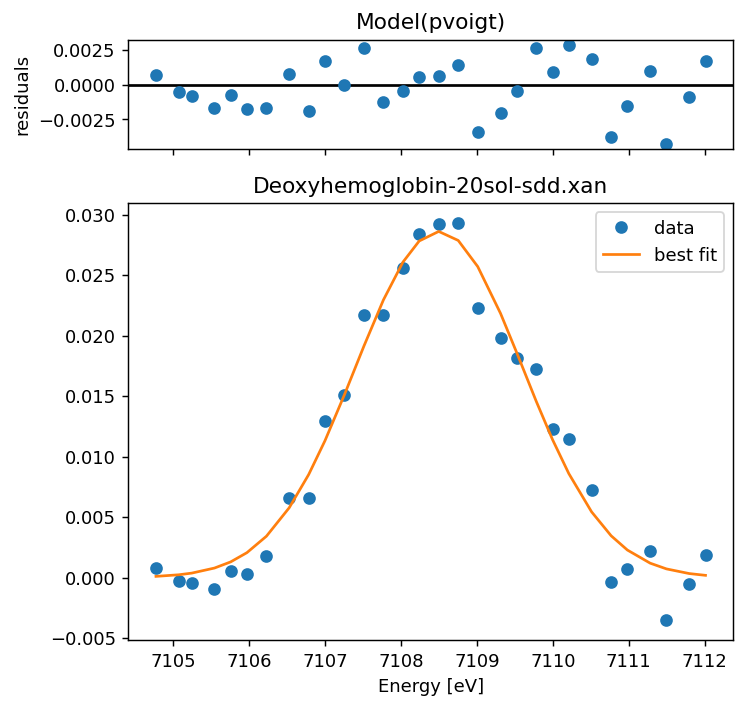

In [38]:
# Shoe pre-edge peak fitting result
fig = plt.figure(dpi=130,figsize=(6,6))
result.plot(fig=fig)
plt.title(spectrum[2][data_num])
plt.xlabel("Energy [eV]")
plt.ylabel("")

plt.show()